In [25]:
# Load experimental results from files.

from pathlib import Path
import re
import yaml
from yaml import SafeLoader

EXP_PATH = "/home/hazrael/GitRepositories/storalloc-gitlab/simulation/results"
EXP_NAME = ["exp__09-Mar-22_09-46", "exp__09-Mar-22_13-05"]

exp_data = []

infra_pattern = re.compile(r"infra\d+TB")
system_pattern = re.compile(r"(single|multi)(_[a-z]+){3}")
algo_pattern = re.compile(r"(\S+)_infra\d+TB")

for name in EXP_NAME:
    exp_path = Path(f"{EXP_PATH}/{name}")
    result_files = exp_path.glob("*.yml")

    for file in result_files:
        with open(file, "r", encoding="utf-8") as yaml_file:
            exp = yaml.load(yaml_file, Loader=SafeLoader)
            exp["full_name"] = file.stem.split('__')[1]
            exp["infra"] = infra_pattern.findall(exp["full_name"])[0]
            exp["system"] = system_pattern.search(exp["full_name"])[0]
            exp["algo"] = algo_pattern.search(exp['full_name'])[1]
            exp_data.append(exp)

In [26]:
# Load them (almost) unprocessed into a DataFrame

import pandas as pd

df_data = pd.DataFrame(exp_data)
# df_data

In [27]:
# Compute some means (per node / disk) extracted from the "nodes" column 
# and add them as new columns in the original dataset

# New columns
mean_node_alloc = [] # extracted from existing field
max_node_alloc = []
mean_node_utilisation = []


for idx, row in df_data.iterrows():

    acc_mean_node_alloc = []
    acc_max_disk_alloc = []
    acc_mean_cap_utilisation = []
    print(row['nodes'])
    # NODES
    for node in row["nodes"]:
        print(node)
        
        acc_mean_node_alloc.append(node["mean_nb_alloc"])
        
        max_disk_alloc = []
        mean_disk_alloc = []
        max_cap_utilisation = []
        mean_cap_utilisation = []

        # DISKS
        for disk in node["disks"]:
            print(disk["max_alloc"])
            acc_max_disk_alloc.append(disk["max_alloc"])
            mean_disk_alloc.append(disk["mean_nb_alloc"])
            max_cap_utilisation.append(disk["max_cap_utilisation"])
            mean_cap_utilisation.append(disk["mean_capacity_utilisation"])
        
        
        mean_disk_alloc = pd.Series(mean_disk_alloc).mean()
        acc_mean_cap_utilisation = pd.Series(mean_cap_utilisation).mean()
    
    # Building future column for DataFrame
    mean_node_alloc.append(pd.Series(acc_mean_node_alloc).mean())
    max_node_alloc.append(max(acc_max_disk_alloc))
    mean_node_utilisation.append(pd.Series(acc_mean_cap_utilisation).mean())
    
    
df_data["mean_node_alloc"] = mean_node_alloc
df_data["max_node_alloc"] = max_node_alloc
df_data["mean_node_utilisation"] = mean_node_utilisation

[{'disks': [{'capacity': 1000, 'id': 0, 'last_alloc_time': 1609441000, 'max_alloc': 169, 'max_cap_utilisation': 100.0, 'mean_capacity_utilisation': 24.553, 'mean_nb_alloc': 0.574}], 'id': 'S-68b960:0', 'last_alloc_ts': 1609441000, 'mean_nb_alloc': 0.574}, {'disks': [{'capacity': 1000, 'id': 0, 'last_alloc_time': 1609443332, 'max_alloc': 40, 'max_cap_utilisation': 100.0, 'mean_capacity_utilisation': 26.401, 'mean_nb_alloc': 0.362}], 'id': 'S-68b960:1', 'last_alloc_ts': 1609443332, 'mean_nb_alloc': 0.362}, {'disks': [{'capacity': 1000, 'id': 0, 'last_alloc_time': 1609443332, 'max_alloc': 133, 'max_cap_utilisation': 100.0, 'mean_capacity_utilisation': 24.341, 'mean_nb_alloc': 0.399}], 'id': 'S-68b960:2', 'last_alloc_ts': 1609443332, 'mean_nb_alloc': 0.399}, {'disks': [{'capacity': 1000, 'id': 0, 'last_alloc_time': 1609441000, 'max_alloc': 42, 'max_cap_utilisation': 100.0, 'mean_capacity_utilisation': 24.021, 'mean_nb_alloc': 0.387}], 'id': 'S-68b960:3', 'last_alloc_ts': 1609441000, 'mean_

In [28]:
df_data.describe()

,max_concurrent_allocations,nb_of_delayed_requests,nb_of_registrations,nb_of_requests,nb_of_scheduler_failures,sim_duration,sim_first_ts,sim_last_ts,tt_gb_allocated,tt_gb_deallocated,tt_waiting_time_minutes,mean_node_alloc,max_node_alloc,mean_node_utilisation
count,32.000000,32.000000,32.0,32.000000,32.000000,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,32.000000,32.000000,32.000000,32.000000
mean,139.031250,0.937500,1.0,18276.781250,208.718750,2.470853e+07,1.577931e+09,1.602640e+09,9.001483e+05,9.001483e+05,109125.000000,1.442281,79.375000,8.677781
std,77.401127,2.526473,0.0,10521.078151,420.029126,1.206659e+07,0.000000e+00,1.206659e+07,4.675255e+05,4.675255e+05,293782.424429,1.295237,77.164153,20.159317
min,2.000000,0.000000,1.0,13.000000,0.000000,6.402790e+05,1.577931e+09,1.578572e+09,1.331942e+03,1.331942e+03,0.000000,0.016375,1.000000,0.012000
25%,140.000000,0.000000,1.0,18332.500000,0.000000,2.532659e+07,1.577931e+09,1.603258e+09,9.193734e+05,9.193734e+05,0.000000,0.383125,20.000000,0.611875
50%,183.000000,0.000000,1.0,24255.000000,0.000000,3.151556e+07,1.577931e+09,1.609447e+09,1.164726e+06,1.164726e+06,0.000000,0.766125,36.500000,1.210375
75%,183.000000,0.000000,1.0,24255.000000,67.250000,3.151556e+07,1.577931e+09,1.609447e+09,1.164726e+06,1.164726e+06,0.000000,3.065000,169.000000,3.986687
max,183.000000,8.000000,1.0,24255.000000,1396.000000,3.151556e+07,1.577931e+09,1.609447e+09,1.164726e+06,1.164726e+06,918000.000000,3.065000,183.000000,95.188000


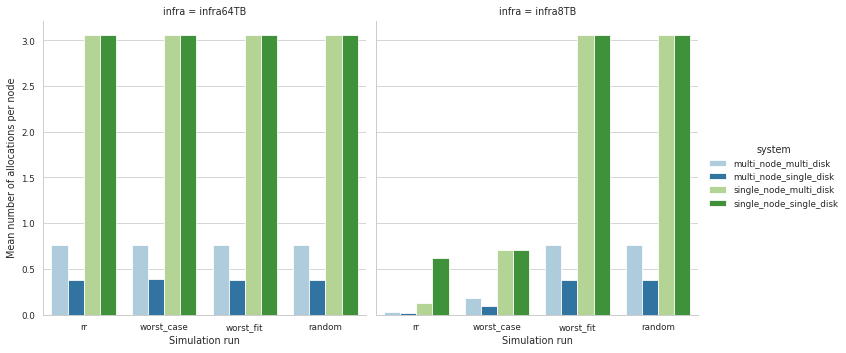

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

df_data = df_data.sort_values(["system",], ascending=True)

categorical_theme = {
    "context": "paper",            
    "palette": "Paired", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}


# [1] --- Mean number of allocations per node, for every algorithm

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="mean_node_alloc", hue="system", col="infra",
    height=5
)
g.set(ylabel="Mean number of allocations per node", xlabel="Simulation run")

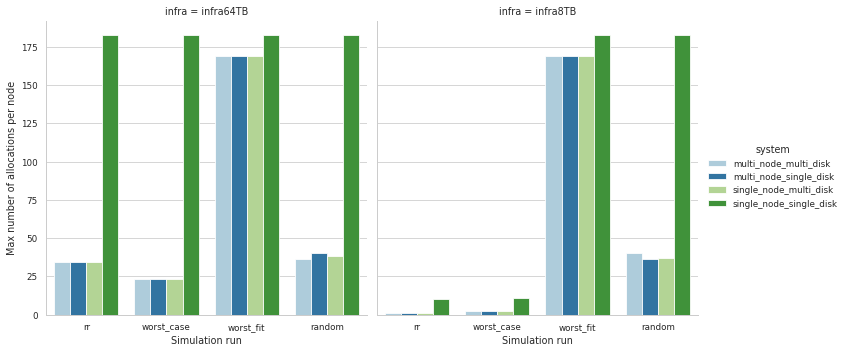

In [53]:
# [2] ---  Max number of allocations per node, for every algo (main parameters of the simulation are in its name)

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_alloc", hue="system", col="infra",
    height=5
)
g.set(ylabel="Max number of allocations per node", xlabel="Simulation run")

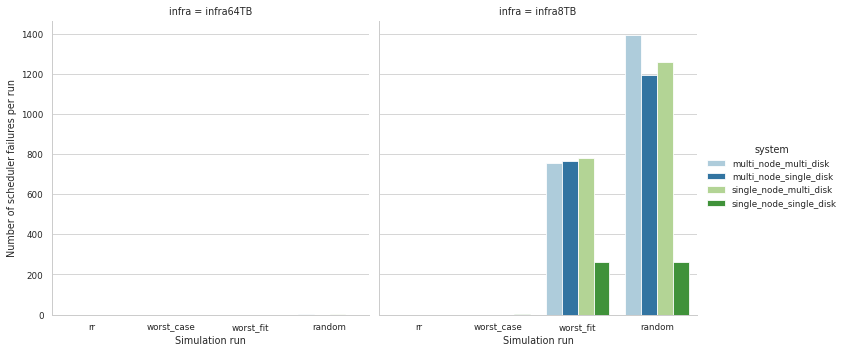

In [54]:
# [3] ---  Total number of scheduler failures, for every simulation

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_scheduler_failures", hue="system", col="infra",
    height=5
)
g.set(ylabel="Number of scheduler failures per run", xlabel="Simulation run")

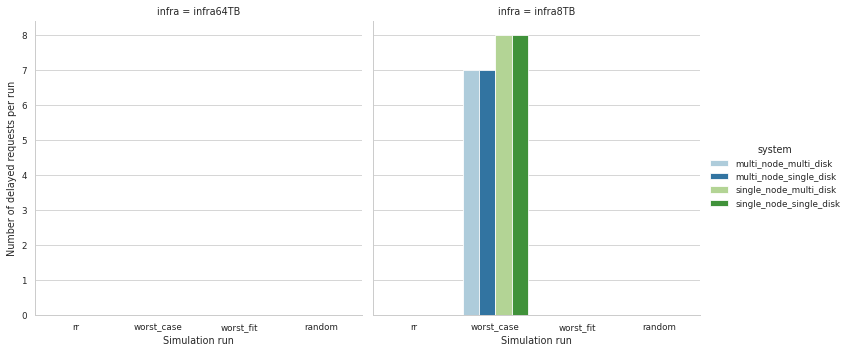

In [56]:
# [4] ---  Total number of delayed requests, for every simulation 

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_delayed_requests", hue="system", col="infra",
    height=5
)
g.set(ylabel="Number of delayed requests per run", xlabel="Simulation run")

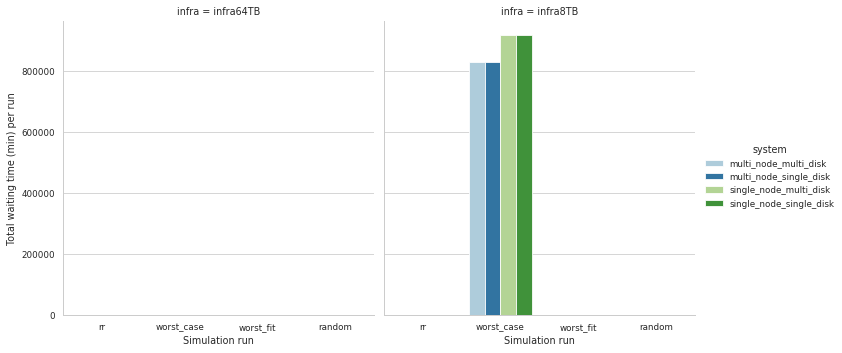

In [57]:
# [5] ---  Total cumulated waiting time for delayed requests, for every simulation
sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_waiting_time_minutes", hue="system", col="infra",
    height=5
)
g.set(ylabel="Total waiting time (min) per run", xlabel="Simulation run")

In [34]:
# [6] ---  Create a second dataset where each row is a disk (instead of having one simulation per row)

data_by_disk = {
    "run_name": [],
    "node_id": [],
    "disk_id": [],
    "full_disk_id": [],
    "disk_mean_nb_alloc": [],
    "disk_max_nb_alloc": [],
    "disk_mean_cap_percent": [],
    "disk_max_cap_percent": [],
    "disk_capacity": [],
    "infra": [],
    "system": [],
    "algo": []
}

for idx, row in df_data.iterrows():
    for node in row['nodes']:
        for disk in node["disks"]:
            data_by_disk["run_name"].append(row['full_name'])
            data_by_disk["node_id"].append(node['id'])
            data_by_disk["disk_id"].append(disk['id'])
            data_by_disk["full_disk_id"].append(f"{node['id']}:{disk['id']}")
            data_by_disk["disk_mean_nb_alloc"].append(disk['mean_nb_alloc'])
            data_by_disk["disk_max_nb_alloc"].append(disk['max_alloc'])
            data_by_disk["disk_mean_cap_percent"].append(disk['mean_capacity_utilisation'])
            data_by_disk["disk_max_cap_percent"].append(disk['max_cap_utilisation'])
            data_by_disk["disk_capacity"].append(disk['capacity'])
            data_by_disk["infra"].append(row['infra'])
            data_by_disk["system"].append(row['system'])
            data_by_disk["algo"].append(row['algo'])
    
data_by_disk = pd.DataFrame(data_by_disk)
data_by_disk

,run_name,node_id,disk_id,full_disk_id,disk_mean_nb_alloc,disk_max_nb_alloc,disk_mean_cap_percent,disk_max_cap_percent,disk_capacity,infra,system,algo
0,rr_infra64TB_multi_node_multi_disk_IOJobs,S-97e01c:0,0,S-97e01c:0:0,0.379,33,0.862,50.000,8000,infra64TB,multi_node_multi_disk,rr
1,rr_infra64TB_multi_node_multi_disk_IOJobs,S-97e01c:0,1,S-97e01c:0:1,0.400,34,4.895,37.500,8000,infra64TB,multi_node_multi_disk,rr
2,rr_infra64TB_multi_node_multi_disk_IOJobs,S-97e01c:1,0,S-97e01c:1:0,0.383,33,0.495,50.000,8000,infra64TB,multi_node_multi_disk,rr
3,rr_infra64TB_multi_node_multi_disk_IOJobs,S-97e01c:1,1,S-97e01c:1:1,0.382,30,1.383,50.000,8000,infra64TB,multi_node_multi_disk,rr
4,rr_infra64TB_multi_node_multi_disk_IOJobs,S-97e01c:2,0,S-97e01c:2:0,0.381,32,1.390,47.400,8000,infra64TB,multi_node_multi_disk,rr
...,...,...,...,...,...,...,...,...,...,...,...,...
195,rr_infra8TB_single_node_single_disk_IOJobs,S-7feed8:0,0,S-7feed8:0:0,0.620,10,3.363,87.500,8000,infra8TB,single_node_single_disk,rr
196,worst_fit_infra8TB_single_node_single_disk_IOJobs,S-41f21d:0,0,S-41f21d:0:0,3.065,183,5.400,100.000,8000,infra8TB,single_node_single_disk,worst_fit
197,rr_infra64TB_single_node_single_disk_IOJobs,S-4dd2d8:0,0,S-4dd2d8:0:0,3.065,183,0.601,45.588,64000,infra64TB,single_node_single_disk,rr
198,worst_case_infra64TB_single_node_single_disk_I...,S-d7d73c:0,0,S-d7d73c:0:0,3.065,183,0.601,45.588,64000,infra64TB,single_node_single_disk,worst_case


In [35]:
data_by_disk = data_by_disk.sort_values(["algo",], ascending=True)

In [36]:
categorical_theme_disk = {
    "context": "paper",            
    "palette": "colorblind", 
    "style": "whitegrid", 
}

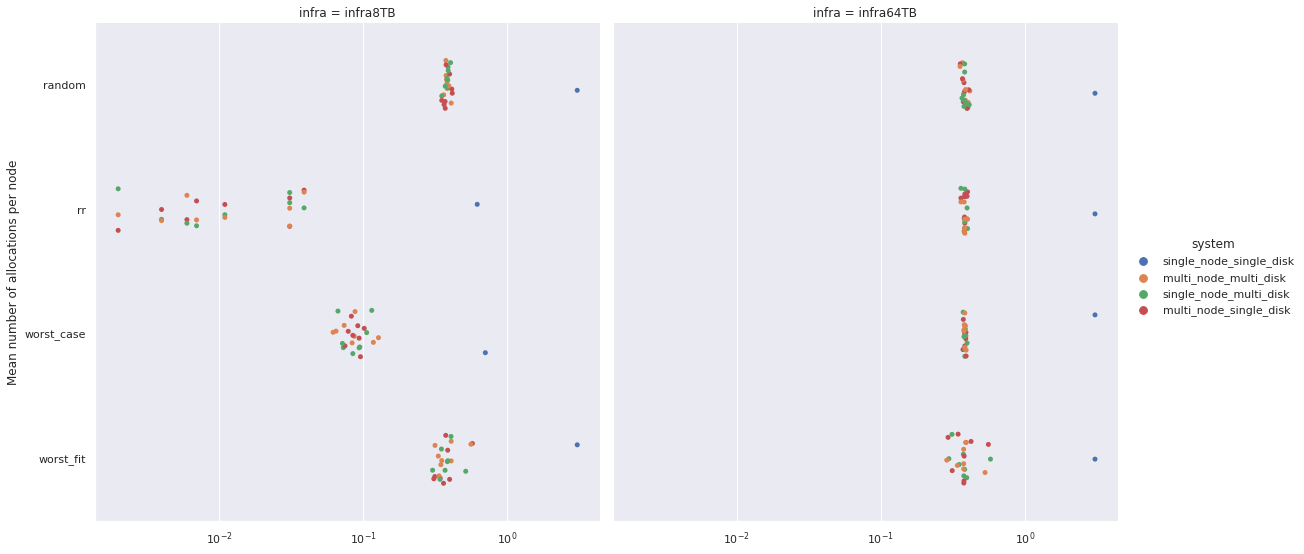

In [63]:
# [7] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip",
    y="algo", x="disk_mean_nb_alloc",hue="system", col="infra",
    height=8, jitter=0.2
)
g.set(xscale="log")
g.set_axis_labels("", "Mean number of allocations per node")

[Text(0, 0.5, 'Simulation run'),
 Text(0.5, 0, 'Mean number of allocations per node')]

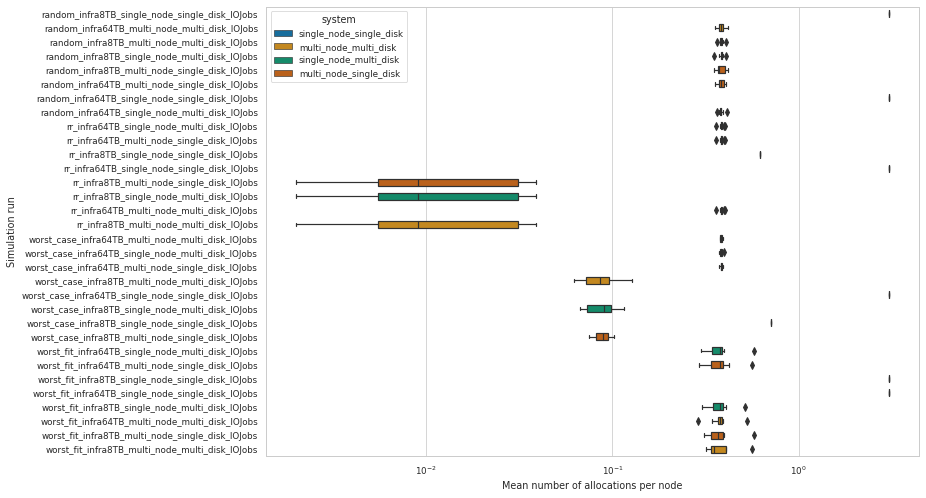

In [65]:
# [8] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="run_name", x="disk_mean_nb_alloc", hue="system", 
    dodge=False, width=0.5
)
g.set(xscale="log")
g.set(ylabel="Simulation run", xlabel="Mean number of allocations per node")

[Text(0, 0.5, 'Mean nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

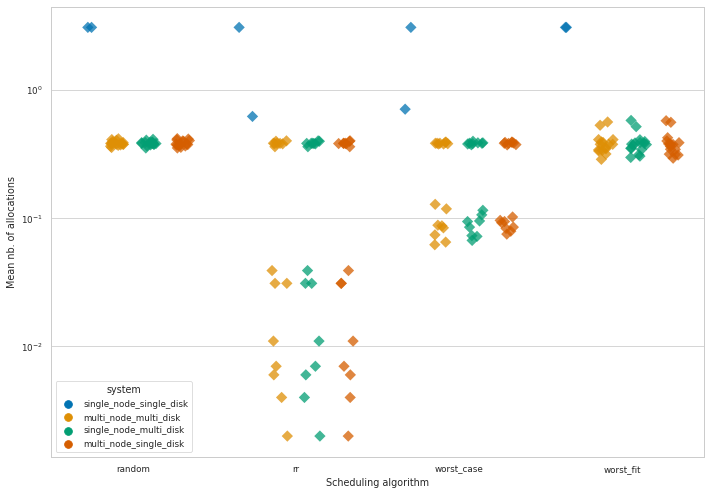

In [68]:
# [9] ---  Mean number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(yscale="log")
g.set(ylabel="Mean nb. of allocations", xlabel="Scheduling algorithm")

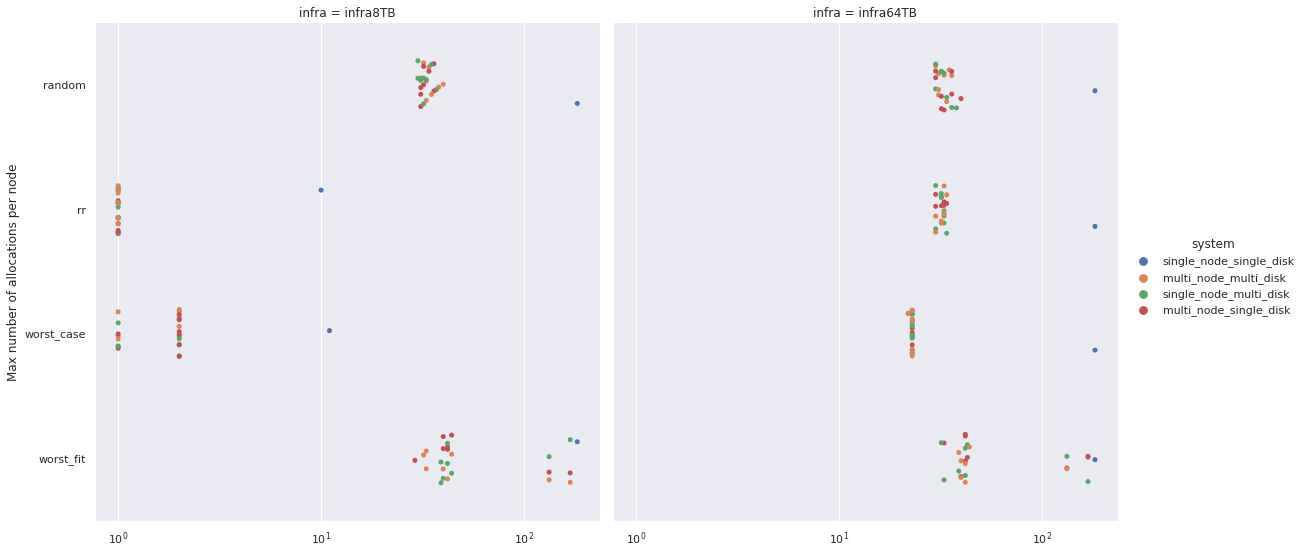

In [73]:
# [10] ---  Max number of allocations per disk, organised by simulation run and infrastructure (1/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip", col="infra",
    y="algo", x="disk_max_nb_alloc",hue="system",
    height=8, jitter=0.2,
)
g.set(xscale="log")
g.set_axis_labels("", "Max number of allocations per node")

[Text(0, 0.5, 'Simulation run'),
 Text(0.5, 0, 'Max number of allocations per node')]

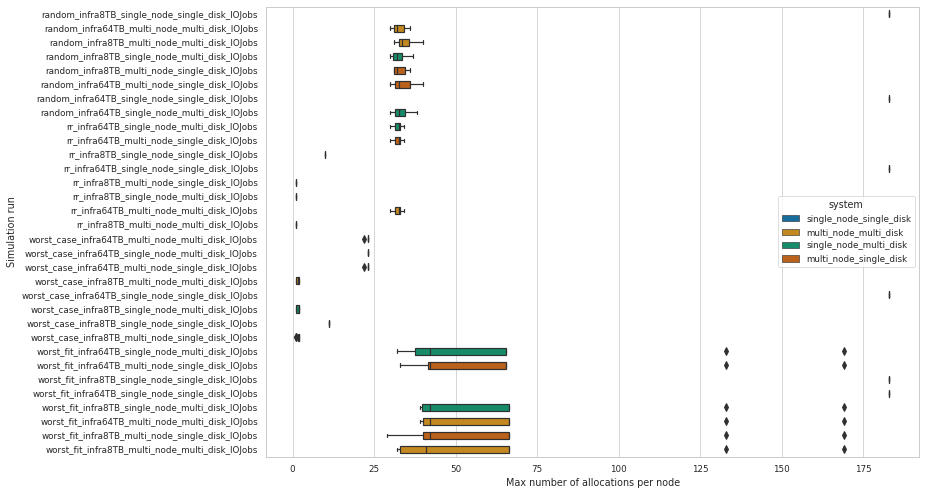

In [41]:
# [11] ---  Max number of allocations per disk, organised by simulation run and infrastructure (2/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="run_name", x="disk_max_nb_alloc", hue="system", 
    dodge=False, width=0.5
)
g.set(ylabel="Simulation run", xlabel="Max number of allocations per node")

[Text(0, 0.5, 'Max nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

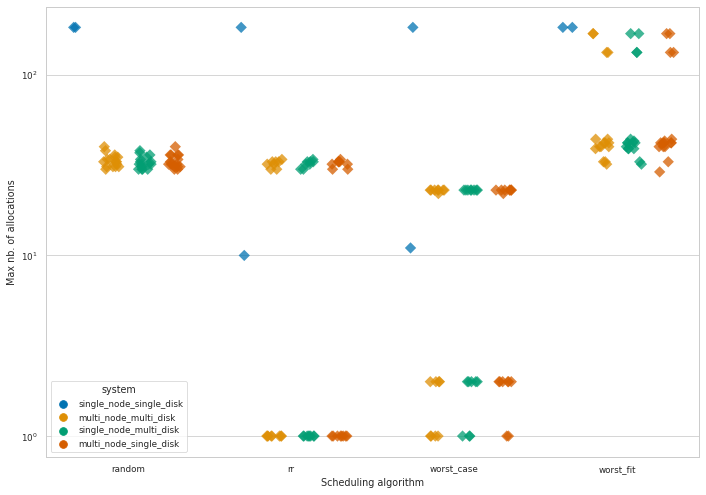

In [42]:
# [12] ---  Max number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(yscale="log")
g.set(ylabel="Max nb. of allocations", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Mean capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

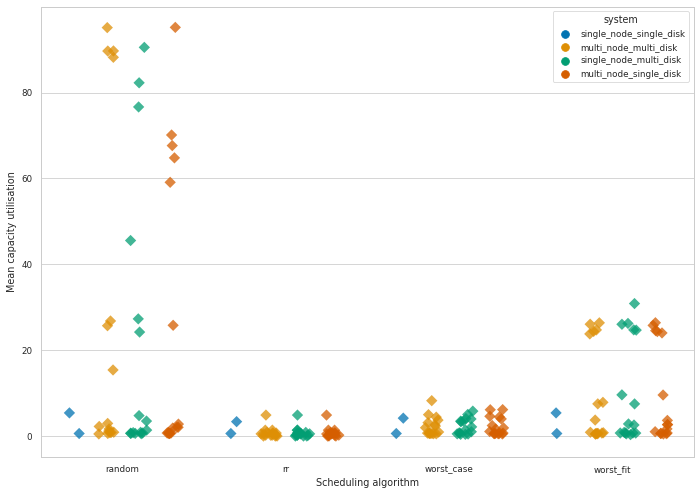

In [43]:
# [13] ---  Mean capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Mean capacity utilisation", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Max capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

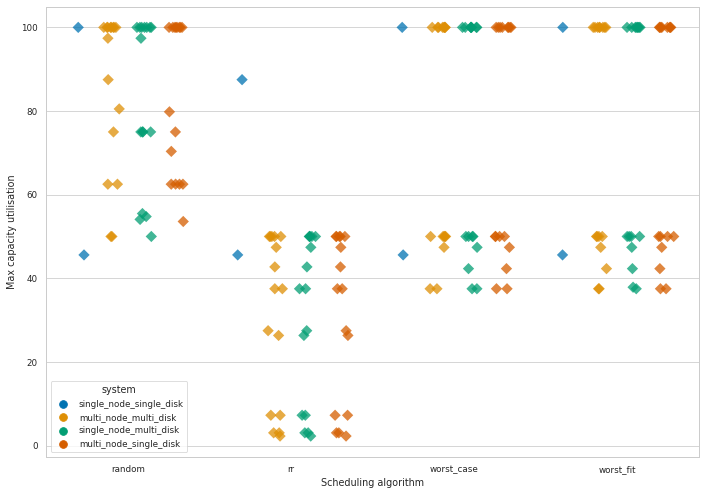

In [44]:
# [14] --- Max capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Max capacity utilisation", xlabel="Scheduling algorithm")

In [45]:
data_by_disk_mean_alloc = data_by_disk.sort_values(["disk_mean_nb_alloc",], ascending=True)

[None]

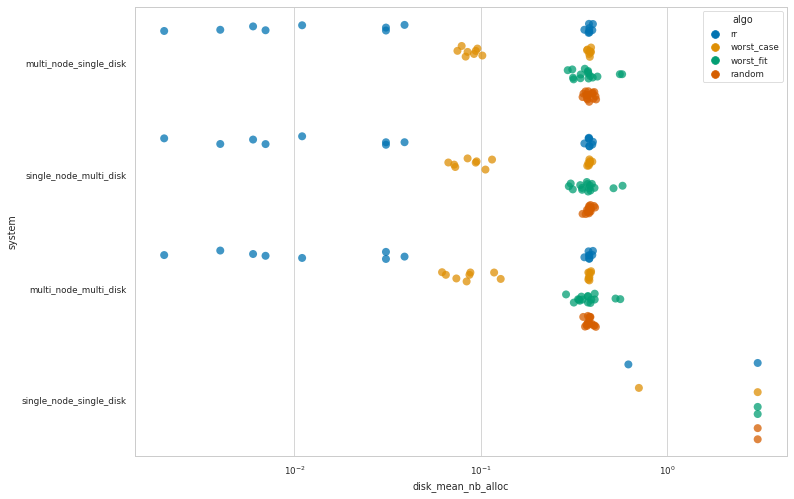

In [46]:
# [15] --- Disk mean nb alloc per run, with hue on Node ID 

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk_mean_alloc,
    y="system", x="disk_mean_nb_alloc",size=8, jitter=0.2, alpha=0.75,
    dodge=True,
    hue="algo"
)
g.set(xscale="log")


# g.xaxis.grid(True, "minor", linewidth=.25)
#g = sns.catplot(x="disk_mean_nb_alloc", y="run_name",
#                hue="node_id",
#                data=data_by_disk_sorted, kind="swarm",
#                alpha=.6, height=21, aspect=29.7/21);

#g.set(xscale="log")
# g.xaxis.grid(True, "minor", linewidth=.25)

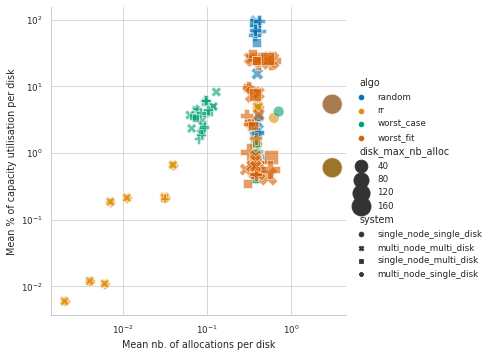

In [47]:
# [16] --- Disk mean nb of alloc compared to disk mean capacity utilisation

sns.set_theme(**categorical_theme_disk)

sns.set_style("whitegrid")
g = sns.relplot(
    x="disk_mean_nb_alloc", 
    y="disk_mean_cap_percent", 
    hue="algo", 
    style="system",
    size="disk_max_nb_alloc",
    sizes=(100, 400), 
    alpha=.60,
    height=5, 
    data=data_by_disk
)
g.set(
    xscale="log", 
    yscale="log", 
    xlabel="Mean nb. of allocations per disk", 
    ylabel="Mean % of capacity utilisation per disk"
)

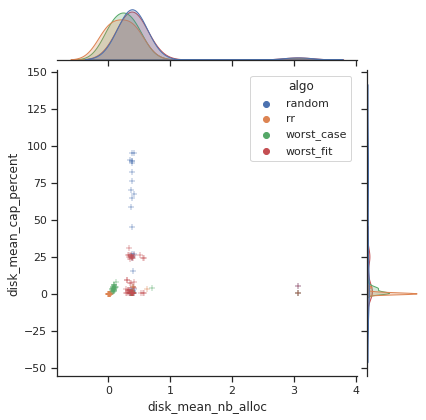

In [48]:
# [16] ---

sns.set_theme(style="ticks")

cmap = sns.hls_palette(n_colors=data_by_disk['algo'].nunique())

g = sns.jointplot(data=data_by_disk, x="disk_mean_nb_alloc", 
                  y="disk_mean_cap_percent", 
                  hue="algo", marker="+")
#g.set(
#    xscale="log", 
#    yscale="log", 
#    xlabel="Mean nb. of allocations per disk", 
#    ylabel="Mean % of capacity utilisation per disk"
#)